# Analyzing NYC High School Data

This project is to explore relationships between SAT scores and demographic factors in New York City public schools. The project investigate the following files:

SAT scores by school - SAT scores for each high school in New York City

School attendance - Attendance information for each school in New York City

Class size - Information on class size for each school

AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

Graduation outcomes - The percentage of students who graduated, and other outcome information

Demographics - Demographic information for each school

School survey - Surveys of parents, teachers, and students at each school

## Process and Combine data

#### Read in the data

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

#### Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [4]:
data['hs_directory'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 58 columns):
dbn                                 435 non-null object
school_name                         435 non-null object
boro                                435 non-null object
building_code                       435 non-null object
phone_number                        435 non-null object
fax_number                          423 non-null object
grade_span_min                      435 non-null object
grade_span_max                      435 non-null int64
expgrade_span_min                   33 non-null object
expgrade_span_max                   33 non-null float64
bus                                 434 non-null object
subway                              358 non-null object
primary_address_line_1              435 non-null object
city                                435 non-null object
state_code                          435 non-null object
zip                                 435 non-null int64
we

#### Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### Convert  SAT score columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### Condense datasets by DBN

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### Combine the datasets by DBN

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Analyzing Data

### 1. Find SAT score correlation factors

In [11]:
#### Correlation of SAT score to survey fields 

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

#### Plotting survey and SAT score correlations

In [12]:
# Remove DBN since it's a unique identifier, not a 
# useful numerical value for correlation.

survey_fields.remove("DBN")
survey_fields.append('sat_score')


In [13]:
survey_sat_correlations = combined[survey_fields].corr()['sat_score']
survey_sat_correlations

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
sat_score     1.000000
Name: sat_score, dtype: float64

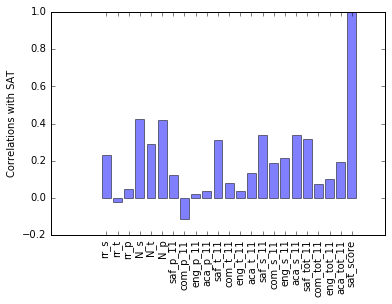

In [14]:
y_pos = np.arange(len(survey_fields))
plt.bar(y_pos, survey_sat_correlations, alpha=0.5, align='center')
plt.xticks(y_pos, survey_fields, rotation=90)
plt.ylabel('Correlations with SAT')
plt.show()

Columns having moderate correlation with sat_score:
N_S (number of student respondents) 0.45
N_P (number of parent respondents) 0.45

Columns having weak correlation with sat_score:
saf_t_11 (safety and respect score based on teacher responses) 0.31
saf_s_11 (safety and respect score based on student responses) 0.34
saf_total_11 (safety and respect total score) 0.32
aca_s_11 (academic expectation score based on student responses) 0.33

It is interesting to find that a school's SAT scores are correlated with the number of survey respondents in that school as well as safety and respect scores from that school.

One possible explanation for the correlatioin between school's SAT scores and number of survey respondent is that willingness to respond to survey reflects the degree of attention students/parents pay to SAT topics.  Another possible explanation is that the high SAT score achievers are more willing to take the SAT survey, while low score achievers feel ashame to take the survey. 

High safety and respect scores reflect the amount of attention students pay to teachers and rules.  These two scores may reflect student's discipline which would lead to better study in school.  




### 2. Investigate satety scores

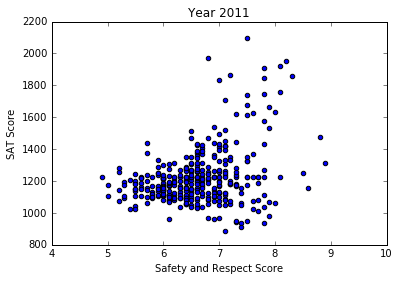

In [15]:
fg, ax = plt.subplots()
ax.scatter(combined['saf_s_11'], combined['sat_score'])
ax.set_xlabel('Safety and Respect Score')
ax.set_ylabel('SAT Score')
ax.set_title('Year 2011')
plt.show()

It seems that SAT score does have a high correlation with safety and respect score.  There is a cluster of low safe score and low SAT score.


#### Map out safety scores over district

In [16]:
safety_district = combined.loc[:, ['saf_s_11','lon', 'lat', 'school_dist']]
safety_district['lon'] = pd.to_numeric(safety_district['lon'], errors='coerce')
safety_district['lat'] = pd.to_numeric(safety_district['lat'], errors='coerce')
safety_district = safety_district.groupby('school_dist').agg(np.mean)
safety_district.reset_index(inplace=True)
safety_district.head()


,school_dist,saf_s_11,lon,lat
0,01,6.768611,-73.982377,40.719022
1,02,6.910660,-73.991386,40.739699
2,03,6.716667,-73.977370,40.781574
3,04,6.885714,-73.943215,40.793449
4,05,6.314286,-73.949251,40.817077


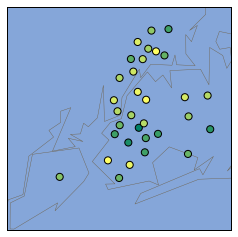

In [19]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
        projection='merc',
        llcrnrlat=40.496044,
        urcrnrlat=40.915256,
        llcrnrlon=-74.255735,
        urcrnrlon=-73.700272,
        resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = safety_district['lon'].tolist()
latitudes = safety_district['lat'].tolist()
#m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=safety_district['saf_s_11'], cmap='summer')
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=safety_district['saf_s_11'], cmap='summer')
plt.show()

Most schools in Manhattan, about half of Queens schools and 2 schools in Brooklyn have high safety scores.

### 3. Investigate racial differences in SAT performance

In [17]:
racialcols = ['white_per','asian_per','black_per','hispanic_per', 'sat_score']
racials = combined.loc[:, racialcols]
racials.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 0 to 362
Data columns (total 5 columns):
white_per       363 non-null float64
asian_per       363 non-null float64
black_per       363 non-null float64
hispanic_per    363 non-null float64
sat_score       363 non-null float64
dtypes: float64(5)
memory usage: 17.0 KB


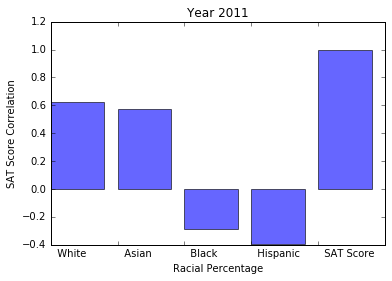

In [22]:
racials_corr = racials.corr()['sat_score']
y_pos = np.arange(len(racials_corr))
colnames = ['  White','  Asian','  Black','  Hispanic', '  SAT Score']
fig, ax = plt.subplots()
ax.bar(y_pos, racials_corr, alpha=.6)
ax.set_xticklabels(colnames, horizontalalignment='left')
ax.set_ylabel('SAT Score Correlation')
ax.set_xlabel('Racial Percentage')
ax.set_title('Year 2011')
plt.show()

A school's SAT scores have a positive correlation with the percentage of White or Asian students among the student population.  On the other hand, a negative correlation is observed between SAT scores and the percentage of Black or Hispanic students.  The data set does not contain additional information that could provide possible explanation for these observations.

### 4. Research about gender and SAT performance

In [ ]:
#### Correlations between genders and SAT score

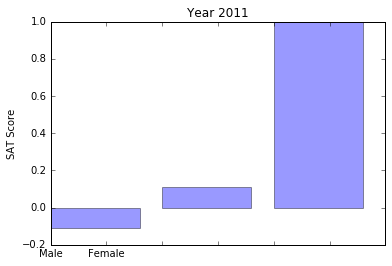

In [19]:
genders = combined.loc[:, ['male_per', 'female_per', 'sat_score']]
genders_corr = genders.corr()['sat_score']
y_pos = np.arange(len(genders_corr))
fig,ax = plt.subplots()
ax.bar(y_pos, genders_corr, alpha=0.4)
ax.set_xticklabels(['Male', 'Female'])
ax.set_ylabel('SAT Score')
ax.set_title('Year 2011')
plt.show()

There is no correlation between gender and SAT score.

#### Investigate schools with high SAT scores and a high female percentage

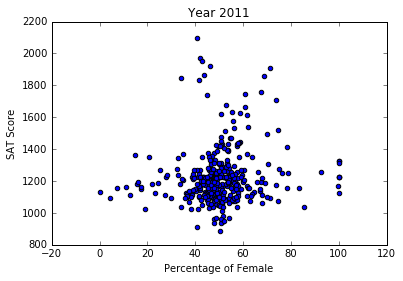

In [20]:
fig, ax = plt.subplots()
ax.scatter(combined['female_per'], combined['sat_score'])
ax.set_xlabel('Percentage of Female')
ax.set_ylabel('SAT Score')
ax.set_title('Year 2011')
plt.show()

#### Research any schools with a female_per greater than 60% and an average SAT score greater than 1700

In [21]:
female_per_gt60 = combined['female_per'] > 0.6
sat_score_gt1700 = combined['sat_score'] > 1700
schools = combined[female_per_gt60 & sat_score_gt1700]['school_name']
#schools.head(2)
schools

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
37                                Stuyvesant High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
79     High School for Mathematics, Science and Engin...
151                         Bronx High School of Science
155    High School of American Studies at Lehman College
187                       Brooklyn Technical High School
198                           Brooklyn Latin School, The
302                          Townsend Harris High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

### 5.  Investigate correlation of the percentage of students who took at least on AP exam and SAT performance